<a href="https://colab.research.google.com/github/uahuser00000/shin_final_cpe490590/blob/main/CIFAR_10_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay

import pandas as pd
import random
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torch.utils.data import Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Change data path to where cifar-10 data is located in your drive
import sys
import os
data_path = "/content/drive/MyDrive/cpe590/final/data/cifar-10-batches-py/"
os.chdir(data_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Class to unpickle the dataset
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
# Load class names
meta = unpickle('batches.meta')
class_names = [name.decode('utf-8') for name in meta[b'label_names']]
print("Class names:", class_names)

Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
# Load training data
images_train, labels_train = [], []
for i in range(1, 6):
    batch = unpickle(os.path.join(data_path, f'data_batch_{i}'))
    images_train.append(batch[b'data'])
    labels_train.extend(batch[b'labels'])

images_train = np.concatenate(images_train).reshape(-1, 3, 32, 32).astype('float32') / 255.0
labels_train = np.array(labels_train)
img_to_view_train = images_train

# Load test data
batch_test = unpickle('test_batch')
images_test = batch_test[b'data'].reshape(-1, 3, 32, 32).astype('float32') / 255.0
labels_test = np.array(batch_test[b'labels'])
img_to_view_test = images_test


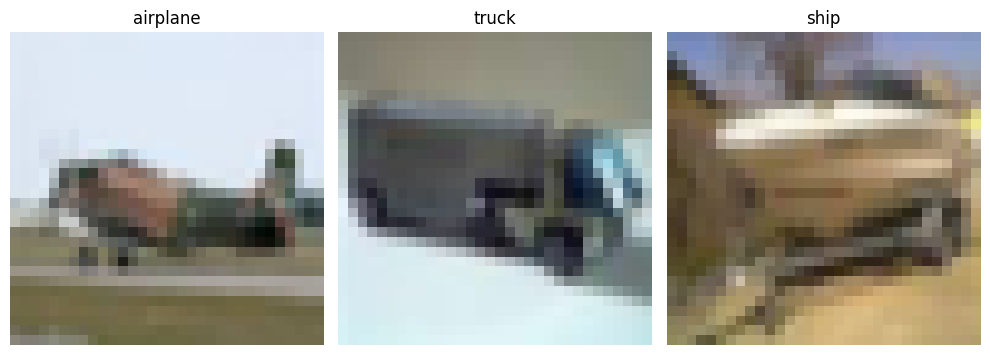

In [ ]:
# Show random images and class
num_img = 3
img_t = img_to_view_train.shape[0]
random_indices = random.sample(range(img_t), num_img)

plt.figure(figsize=(10, 5))
for i, index in enumerate(random_indices):
    plt.subplot(1, num_img, i + 1)
    img = img_to_view_train[index].transpose((1, 2, 0))
    plt.imshow(img)
    plt.title(class_names[labels_train[index]])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Datasets
x_train_np = images_train
y_train_np = labels_train
x_test = torch.tensor(images_test, dtype=torch.float32)
y_test = torch.tensor(labels_test, dtype=torch.long)
x_train_np.shape , x_test.shape , y_train_np.shape , y_test.shape

((50000, 3, 32, 32),
 torch.Size([10000, 3, 32, 32]),
 (50000,),
 torch.Size([10000]))

In [ ]:
# Flatten the images
num_train_samples = x_train_np.shape[0]
num_test_samples = x_test.shape[0]
X_train_flattened = x_train_np.reshape(num_train_samples, -1)
X_test_flattened = x_test.numpy().reshape(num_test_samples, -1)

In [ ]:
# Normalize the pixel values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flattened)
X_test_scaled = scaler.transform(X_test_flattened)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit_transform(X_train_scaled)

array([[-2.2055050e+01,  1.2284679e+01,  8.9611931e+00, ...,
         5.4104696e-03,  1.5846748e-03,  2.1382628e-03],
       [ 4.0133095e+00, -5.0490522e+00,  2.5395908e+01, ...,
        -1.2000006e-03, -3.3230386e-03, -3.6990244e-03],
       [ 2.1112385e+01, -4.7687202e+01, -1.2573562e+01, ...,
        -1.9524610e-03, -2.5883613e-03, -9.7187550e-04],
       ...,
       [-5.7900610e+00, -4.4924389e+01, -4.2472563e+00, ...,
         5.5119814e-03, -5.3215553e-03,  4.6680871e-04],
       [ 4.2391800e+01, -1.6551161e+01,  2.2266012e+01, ...,
        -1.1136137e-03, -3.9388798e-03, -5.3995596e-03],
       [ 1.3075388e+01, -3.1922040e+00, -1.7317469e+01, ...,
        -2.3135492e-03,  1.3979060e-03, -1.9695857e-03]], dtype=float32)

In [ ]:
pca.explained_variance_.shape

(3072,)

In [ ]:
# Calculating optimal number of PCA components
k = 0
total = sum(pca.explained_variance_)
current_sum = 0

while(current_sum / total < 0.98):
    current_sum += pca.explained_variance_[k]
    k += 1
k

448

In [ ]:
pca = PCA(n_components=k, whiten=True, svd_solver='randomized')

x_train_pca = pca.fit_transform(X_train_scaled)
x_test_pca = pca.transform(X_test_scaled)

In [ ]:
clf = svm.SVC(kernel='rbf', C=1.0, gamma='scale')
clf.fit(x_train_pca, y_train_np)

y_pred = clf.predict(x_test_pca)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Evaluate SVM
accuracy_svm = accuracy_score(y_test, y_pred)
f1_svm = f1_score(y_test, y_pred, average='weighted')
report_svm = classification_report(y_test, y_pred)

print('SVM (PCA) Performance:')
print(f"Accuracy: {accuracy_svm:.4f}")
print(f"F1 Score (weighted): {f1_svm:.4f}")
print("\nClassification Report:\n", report_svm)

SVM (PCA) Performance:
Accuracy: 0.5127
F1 Score (weighted): 0.5112

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.56      0.58      1000
           1       0.54      0.65      0.59      1000
           2       0.41      0.38      0.40      1000
           3       0.37      0.39      0.38      1000
           4       0.47      0.41      0.44      1000
           5       0.44      0.40      0.42      1000
           6       0.56      0.55      0.56      1000
           7       0.59      0.55      0.57      1000
           8       0.67      0.62      0.64      1000
           9       0.49      0.62      0.55      1000

    accuracy                           0.51     10000
   macro avg       0.51      0.51      0.51     10000
weighted avg       0.51      0.51      0.51     10000



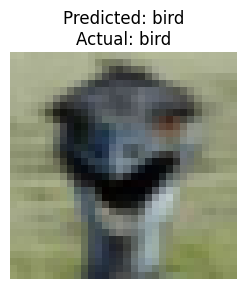

In [ ]:
# Visualize a SVM predictions
num_img_to_show = 1
fig = plt.figure(figsize=(6, 3))
for i in range(num_img_to_show):
    random_index = random.randint(0, len(x_test) - 1)
    ax = fig.add_subplot(1, num_img_to_show, i + 1)
    ax.axis('off')

    # Get the image from the PyTorch tensor, move to CPU, and convert to NumPy
    img_tensor = x_test[random_index].cpu().numpy()

    # Transpose the image from (C, H, W) to (H, W, C)
    img_np = img_tensor.transpose((1, 2, 0))

    ax.imshow(img_np)
    ax.set_title(f'Predicted: {class_names[y_pred[random_index]]}\nActual: {class_names[y_test[random_index]]}')

plt.tight_layout()
plt.show()

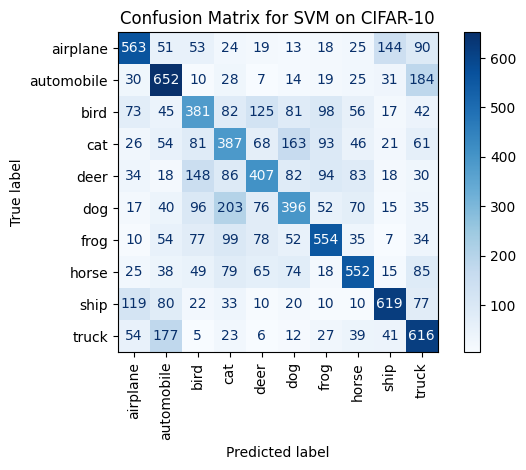

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
y_test_flat = y_test.flatten()
# Calculate the confusion matrix
cm_svm = confusion_matrix(y_test_flat, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', values_format='d')
plt.title('Confusion Matrix for SVM on CIFAR-10')
plt.tight_layout()
plt.show()